In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Для обработки используется =>", device)    

Для обработки используется => cuda


# Постановка задачи

**Описание задачи**

Необходимо обучить нейросеть, способную по входному изображению лица
определять пол человека на изображении.

**Данные**

Для обучения и тестирования будет предоставлен набор из 100 тысяч
картинок, из которых 50 тысяч будут содержать изображения лиц мужчин, а
остальные 50 тысяч - изображения лиц женщин.
Данные можно скачать [отсюда](https://drive.google.com/file/d/1-HUNDjcmSqdtMCvEkVlI0q43qlkcXBdK/view). В загруженном архиве есть две папки, male и
female, с изображениями лиц мужчин и женщин соответственно. Разбить
данные на тренировочный и валидационный сет предлагается
самостоятельно.

**Условия**

В качестве результата необходимо прислать ссылку на github (можно
объединить репозиторий с первой задачей), в котором должны быть:

    1. Тренировочный скрипт или notebook-файл с кодом тренировки.
       Желательно, чтобы код был закомментирован;
       
    2. Модель обученной нейросети (если модель большая - можно ссылкой на любой ресурс в описании);
    
    3. Скрипт для использования нейросети, с помощью которого можно просчитать переданную через аргументы папку с изображениями. Скрипт должен сохранять файл process_results.json с информацией о результатах процессинга.
    
Пример вызова:

python3 process.py folder/to/process/
Пример файла с результатами:
{ ‘img_1.jpg’: ‘male’, ‘img_2.jpg’: ‘female’, ...}

    4. Описание решения, которое должно включать в себя описание процесса подготовки данных, используемой нейросети, параметров обучения, и полученных результатов. Так же в описании должна присутствовать инструкция для запуска тренировки и запуска нейросети.
    
    5. В качестве фреймворка для обучения желательно использовать pytorch
    
**Оценка качества**

Качество модели будет оцениваться по метрике [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision).

P.S.
В исходных данных по 50001 картинке каждого класса

# Решение задачи 

При классификации изоражений использовала модель построения сверточной сети.

Так как до этого не работала с pytorch и сверточными сетями, использовала [данную статью](https://towardsdatascience.com/pytorch-vision-binary-image-classification-d9a227705cf9) как шаблон для построения модели классификации. В виду ограниченности вычислительных ресурсов проводила тренировку сети, предварительно понизив размеры входных изображений до 64 на 64 пикселя.

##  Тренировка модели

### Подготовка данных

Сами данные я не стала загружать в репозиторий. Их можно получить по [ссылке](https://drive.google.com/file/d/1-HUNDjcmSqdtMCvEkVlI0q43qlkcXBdK/view).

In [108]:
# определение папки с изображениями, из которой модель будет подгружать данные
root_dir = "./internship_data"

In [125]:
# определение преобразователя изображений
image_transforms = {
    "data": transforms.Compose([
        transforms.Resize((64, 64)), # приведение изображения к размеру 64х64
        transforms.ToTensor() # приведение изоражения к тензору, который модель будет обрабатывать
    ])
}

In [126]:
# определение места хранения датасета
face_dataset = datasets.ImageFolder(root = root_dir,
                                      transform = image_transforms["data"]
                                     )

In [127]:
# разбивка исходного датасета на обучение и тест (80%/20%)
train_set, test_set = torch.utils.data.random_split(face_dataset, [80000, 20000])

In [128]:
# определение словаря названий классов для вывода на графике
idx2class = {v: k for k, v in face_dataset.class_to_idx.items()}
print(idx2class)

{0: 'female', 1: 'male'}


In [129]:
# определение загрузчиков датасетов
train_loader = DataLoader(dataset=train_set, shuffle=False, batch_size=128)
test_loader = DataLoader(dataset=test_set, shuffle=False, batch_size=1)

In [130]:
# функция, которая подсчитывает число картинок каждого класса в переданном датасете
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

# функция, которая строит график распределения классов
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

In [131]:
# построение графиков распределения классов в обучающем и тестовом датасетах
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, face_dataset), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(test_loader, face_dataset), plot_title="Test Set", ax=axes[1])

Text(0.5, 1.0, 'Test Set')

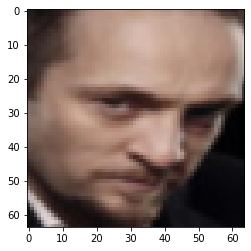

In [132]:
# получение первой картинки из первого пакета картинок
single_batch = next(iter(train_loader))
single_image = single_batch[0][0]
plt.imshow(single_image.permute(1,2,0))

### Построение модели 

Для начала решила попробовать упростить модель нейросети, так как сами данные имеют меньшую размерность по сравнению с той, которая использовалась в статье. Набор слоев оставила тем же:

    1. Сверточный блок с ядром 5 на 5 с 128 фильтрами
    2. Пулинг с ядром 2 на 2 и шагом 2
    3. Сверточный блок с ядром 3 на 3 с 64 фильтрами
    4. Сверточный блок с ядром 3 на 3 с 32 фильтрами
    5. Пулинг с ядром 2 на 2 и шагом 2
    6. Сверточный блок с ядром 16 на 16 с 2 фильтрами

На 1, 3 и 4 этапах помимо свертки выполняется еще:
    
    - пакетная нормализация
    - вычисление выходных значений с помощью функции активации ReLU 
    - дропаут 10% выходных значений 

In [133]:
class FaceClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = self.conv_block(c_in=3, c_out=128, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=64, c_out=32, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=16, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

In [134]:
# инициализация класса модели нейросети, задание устройства, на котором будет производиться расчет
net = FaceClassifier()
net.to(device)
print(net)

FaceClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(32, 2, kernel_size=(16, 16), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [135]:
# определение функции расчета ошибки и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.008)

In [136]:
# определение функции для расчета точности прогнозов в ходе обучения
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [137]:
# определение массивов для хранения точности и ошибки на каждой из итерация обучения
# нужно будет для построения графиков и исследования эффективности полученной модели
accuracy_stats = []
loss_stats = []

In [140]:
# тренировка модели
print("Begin training.")
for e in tqdm(range(1, 21)): # использую библиотеку tqdm для отслеживания процесса обучения
    train_epoch_loss = 0
    train_epoch_acc = 0
    net.train() # приведение модели в состояние "обучение"
    # оптимизация функции ошибки и обновление параметров по каждому пакету картинок из обучающего датасета
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad() # обнуление градиента, так как на каждой итерации нам необходимо рассчитывать его заново
        y_train_pred = net(X_train_batch).squeeze() # прямой проход по нейросети и вычисление пресказаний классов
        try:
            train_loss = criterion(y_train_pred, y_train_batch) # расчет функции ошибки
        except:
            print('ups!')
            print(y_train_pred)
            print(y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch) # расчет точности прогноза
        train_loss.backward() # обратный проход, вычиление градиентов
        optimizer.step() # обновление параметров модели
        
        # накопление ошибки и точности
        train_epoch_loss += train_loss.item() 
        train_epoch_acc += train_acc.item()
    # расчет средних значений ошибки и точности по всем пакетам данных
    loss_stats.append(train_epoch_loss/len(train_loader))
    accuracy_stats.append(train_epoch_acc/len(train_loader))
    # вывод ошибки и точности для текущего этапа обучения
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}')

Begin training.


Epoch 01: | Train Loss: 0.32114 | Train Acc: 86.949
Epoch 02: | Train Loss: 0.20311 | Train Acc: 91.909
Epoch 03: | Train Loss: 0.16431 | Train Acc: 93.426
Epoch 04: | Train Loss: 0.14280 | Train Acc: 94.461
Epoch 05: | Train Loss: 0.12866 | Train Acc: 94.955
Epoch 06: | Train Loss: 0.11921 | Train Acc: 95.362
Epoch 07: | Train Loss: 0.11243 | Train Acc: 95.610
Epoch 08: | Train Loss: 0.10743 | Train Acc: 95.782
Epoch 09: | Train Loss: 0.10378 | Train Acc: 96.008
Epoch 10: | Train Loss: 0.10164 | Train Acc: 96.088
Epoch 11: | Train Loss: 0.09625 | Train Acc: 96.293
Epoch 12: | Train Loss: 0.09523 | Train Acc: 96.438
Epoch 13: | Train Loss: 0.09293 | Train Acc: 96.480
Epoch 14: | Train Loss: 0.08997 | Train Acc: 96.517
Epoch 15: | Train Loss: 0.08865 | Train Acc: 96.581
Epoch 16: | Train Loss: 0.08445 | Train Acc: 96.816
Epoch 17: | Train Loss: 0.08287 | Train Acc: 96.795
Epoch 18: | Train Loss: 0.08054 | Train Acc: 96.979
Epoch 19: | Train Loss: 0.07864 | Train Acc: 96.986
Epoch 20: | 

Вывод графиков процесса обучения (увеличение точности и уменьшение ошибки)

Text(0.5, 1.0, 'Train Loss/Epoch')

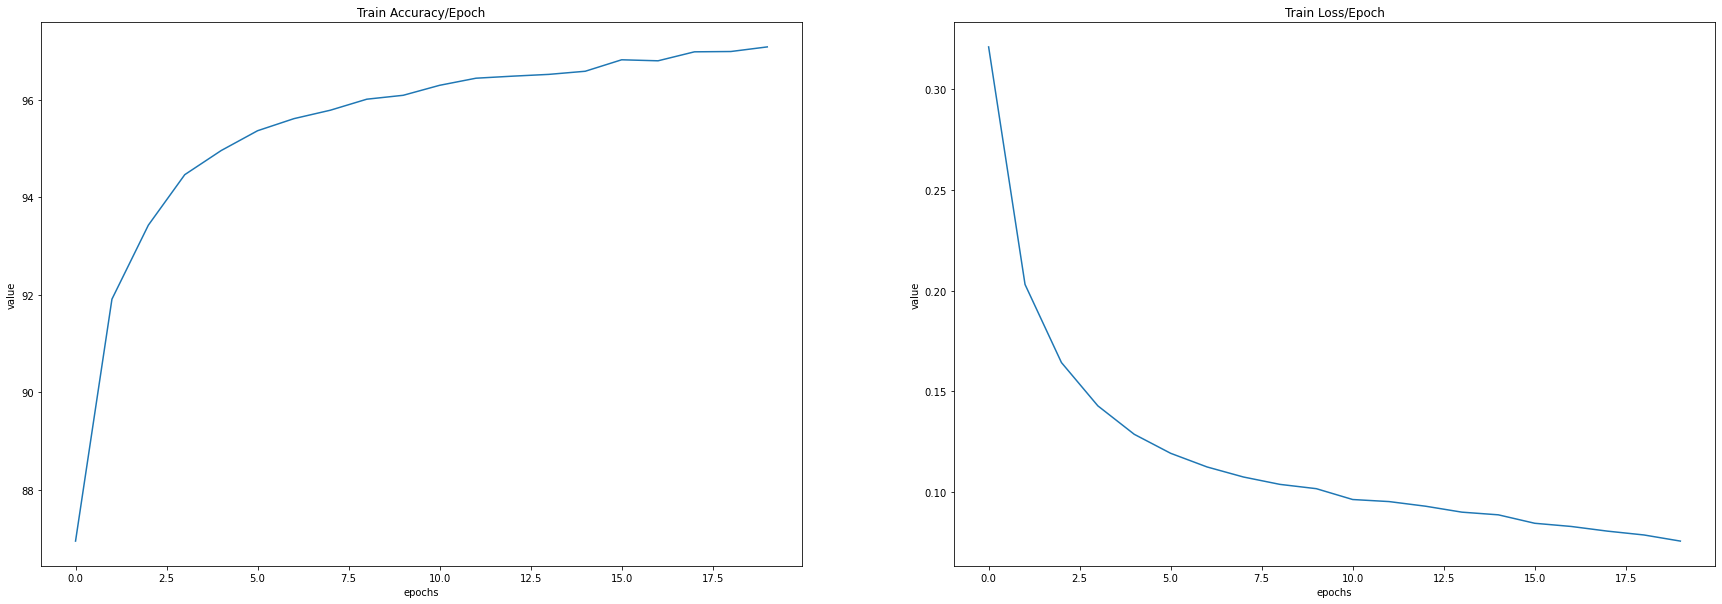

In [143]:
train_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

sns.lineplot(data=train_acc_df, x = "epochs", y="value", ax=axes[0]).set_title('Train Accuracy/Epoch')
sns.lineplot(data=train_loss_df, x = "epochs", y="value", ax=axes[1]).set_title('Train Loss/Epoch')

### Оценка качества модели на тестовых данных

Обход тестового датасета без вычисления градиента и вычисление предсказаний классов

In [144]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = net(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [145]:
y_pred_np = [i[0][0][0] for i in y_pred_list]
y_pred_np = np.array(y_pred_np) 
y_true_np = np.array([i[0] for i in y_true_list])

In [146]:
print("точность на тесте: {} %".format(100 - np.mean(np.abs(y_pred_np - y_true_np)) * 100))

точность на тесте: 95.68 %


### Сохранение модели

In [147]:
torch.save(net.state_dict(), './face_classification_model.pth')

### Скрипт для использования нейросети

In [148]:
import json
import ntpath

# функция для того, чтобы выделить из имени файла с картинкой название картинки без папок
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def process_folder(path):
    # загрузка настроенной модели
    net = FaceClassifier()
    net.load_state_dict(torch.load('./face_classification_model.pth'))
    net.eval()
    
    # загрузка датасета из переданной папки с картинками
    image_transforms = {
    "data": transforms.Compose([
        transforms.Resize((64, 64)), # приведение изображения к размеру 64х64
        transforms.ToTensor() # приведение изоражения к тензору, который модель будет обрабатывать
    ])
    }
    face_dataset = datasets.ImageFolder(root = './' + path,
                                      transform = image_transforms["data"]
                                     )
    face_loader = DataLoader(dataset=face_dataset, shuffle=False, batch_size=1)
    
    # предсказание классов (0 - женщина, 1 - мужчина)
    y_pred_list = []
    image_list = []
    with torch.no_grad():
        for x_batch, _ in face_loader:
            y_test_pred = net(x_batch)
            y_test_pred = torch.log_softmax(y_test_pred, dim=1)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
    
    # формирование списка файлов с предсказаниями
    output_list = []
    class_labels = {0:'female', 1:'male'}
    for y, img in zip(y_pred_list, face_dataset.imgs):
        img_name = path_leaf(img[0])
        y_label = class_labels[int(y[0][0][0])]
        output_list.append({img_name: y_label})
    
    # сохранение в файл json
    with open('processing.json', 'w') as file:
        json.dump(output_list, file)

In [ ]:
process_folder('processing')


# Выводы 

**Результаты:**

С помощью применения модели сверточных сетей достигнут неплохой результат классификации изображений: 95.68% на тестовых данных. Для первого раза неплохо) И даже при том, что из-за граниченности вычислительных ресурсов я не могла строить более сложные модели и обрабатывать картинки в большем разрешении.

**Возникшие трудности:**

Из-за того, что в исходных данных было по 50 001 картинке каждого класса, у мменя при разбивки на батчи оставалась одна картинка в последнем батче и при его обработке возникала ошибка расчета функции ошибки. Насколько мне удалось узнать - это возможно проблема в библиотеках pytorch и нужно было размер батча подбирать таким образом, чтобы не оставался один элемент в последнем пакете. Но я решила привести все к исходной постановке задачи, где всего 100 000 картинок и обрабатывала их. При целом числе батчей одинакового размера ошибки на этапе обучения модели не возникло.

**Что можно улучшить:**

Можно было бы попробовать построить другие, более сложные модели, посмотреть результаты на тесте. И увеличить разрешение картинок. 

Еще заметила, что сами картинки, на которых проводится обучение, достаточно хорошо обрезаны, большую часть картинки занимает именно лицо. И в таком случае, по моим предположениям, при вводе данной модели в эксплуатацию и обработке картинок, на которых лица занимают меньшую часть картинки, точность классификации будет заметно ниже, чем на тесте. По-хорошему перед тем как обрабатывать картинку, в ней нужно будет как-то выделять границы лица и обрезать картинку до этих границ, убирая лишнюю информацию.